In [1]:
import random
from collections import defaultdict, namedtuple
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import bernoulli
from functools import total_ordering

import numpy as np
from itertools import product


@total_ordering
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

width = 10
height = 10


class MDP:
    def __init__(self, lion_pos=(height - 1, 0), cow_positions=([(0, width - 1)])):
        self.lion_i, self.lion_j = lion_pos
        self.cow_positions = cow_positions

        self.START_STATE = (self.lion_i, self.lion_j, tuple(False for _ in cow_positions))
        self.END_STATE = (self.lion_i, self.lion_j, tuple(True for _ in cow_positions))
        
        self.states = self._get_states()
        self.actions = self._get_actions()
        self.transitions = {(s, a): self._move(s, a) for s in self.states for a in self.actions[s]}
        self.reward = self._get_reward()
        
    def reward_transition(self, s, a):
        r = self.reward[(s,a)]
        ss = self.transitions[(s,a)]
        return r,ss
        
    def _cows_vec(s):
        return s[2]
       
    def _valid_state(self, s):
        return s[0] in range(0, height) and s[1] in range(0, width)

    def _try_move(self, s, a):
        next_s = None
        if a == Action.UP:
            next_s = (s[0] - 1, s[1], s[2])
        elif a == Action.DOWN:
            next_s = (s[0] + 1, s[1], s[2])
        elif a == Action.LEFT:
            next_s = (s[0], s[1] - 1, s[2])
        elif a == Action.RIGHT:
            next_s = (s[0], s[1] + 1, s[2])
        return next_s
        
    def _move(self, cell, direction):
        next_cell = self._try_move(cell, direction)
        
        if not self._valid_state(next_cell):
            return cell
        
        if (next_cell[0], next_cell[1]) in self.cow_positions:
            cow_ind = self.cow_positions.index((next_cell[0], next_cell[1]))
            new_cow_vec = tuple(True if i == cow_ind else e for i, e in enumerate(cell[2]))
            next_cell = (next_cell[0], next_cell[1], new_cow_vec)

        return next_cell

    def _get_actions(self):
        actions = {}
        for s in self.states:
            actions[s] = []
            if s[0] > 0:
                actions[s].append(Action.UP)
            if s[0] < height - 1:
                actions[s].append(Action.DOWN)
            if s[1] > 0:
                actions[s].append(Action.LEFT)
            if s[1] < width -1:
                actions[s].append(Action.RIGHT)
                
        return actions

    def _get_reward(self):
        reward_partial = {}

        for s in self.states:
            for a in self.actions[s]:
                next_state = self.transitions[(s, a)]
                if next_state == self.END_STATE:
                    reward_partial[(s, a)] = 100
                if (next_state[0], next_state[1]) in self.cow_positions:
                    cow_ind = self.cow_positions.index((next_state[0], next_state[1]))
                    if not s[2][cow_ind]:
                        reward_partial[(s, a)] = 50

        return defaultdict(int, reward_partial)

    def _get_states(self):
        states = []
        for i in range(height):
            for j in range(width):
                ncows = len(self.cow_positions)
                if (i, j) in self.cow_positions:
                    indx = self.cow_positions.index((i, j))
                    cvs = tuple(prod for prod in product([False, True], repeat=ncows) if prod[indx])
                else:
                    cvs = tuple(product([False, True], repeat=ncows))
                    
                for cw in cvs:
                    states.append((i, j, cw))

        return states

In [2]:
mdp = MDP(cow_positions=[(height - 1,width - 1), (0, width - 1)])

In [3]:
def eps_greedy(mdp, Q, eps, s):    
    best_act = mdp.actions[s][np.argmax(
            [Q[(s, a)] for a in mdp.actions[s]]
        )]
    rand_act = random.choice(mdp.actions[s])
    prob = random.uniform(0, 1)
    if prob < eps:
        return rand_act
    return best_act

In [119]:
R = {(s, a): 0 for s in mdp.states for a in mdp.actions[s]}
T = {(s, a): random.choice(mdp.states) for s in mdp.states for a in mdp.actions[s]}
M = {sa: (r, ss) for sa in R for r in [R[sa]] for ss in [T[sa]]}

In [120]:
def init(mdp):
    Q = {(s, a): 0 for s in mdp.states for a in mdp.actions[s]}

    return Q, M

In [121]:
def dyna_q(mdp, alpha, gamma, n, eps, iter_cnt=None, theta=None):
    iterations = []
    cumrewards = []
    episodes = []

    Q, model = init(mdp)

    niter = 0
    epi_cnt = 0
    cumreward = 0
    visited_states = set([mdp.START_STATE])
    visited_sa = set([])

    ss = mdp.START_STATE
    while niter < iter_cnt:
        s = ss
        if s == mdp.END_STATE:
            epi_cnt += 1
            s = mdp.START_STATE

        # acting
        act = eps_greedy(mdp, Q, eps, s)
        r, ss = mdp.reward_transition(s, act)
#         r = mdp.reward[(s, act)]
#         ss = mdp.transitions[(s, act)]

        visited_states.add(ss)
        visited_sa.add((s,act))
        
        cumreward += r
        cumrewards.append(cumreward)
        iterations.append(niter)
        episodes.append(epi_cnt)
        
        # direct RL
        Q[(s, act)] += alpha * (r + gamma * max([Q[(ss, aa)] for aa in mdp.actions[ss]]) - Q[(s, act)])
        # model learning
        model[(s, act)] = r, ss

        # n-step planning
        for _ in range(n):
            (ps,pa) = random.choice(list(visited_sa))
            r, sss = model[(ps, pa)]
            
            Q[(ps, pa)] += alpha * (r + gamma * np.max([Q[(sss, a)] for a in mdp.actions[sss]]) - Q[(ps, pa)])
        
        niter += 1
    return Q, iterations, episodes, cumrewards

In [122]:
random.seed(42)

In [123]:
import heapq as hq


def dyna_q_prioritized_sweeping(mdp, alpha, gamma, n, eps, theta, maxiter):
    niter = 0
    cumreward = 0
    iterations = []
    cumrewards = []
    
    descendants = {}

    quality, model = init(mdp)
    pqueue = []

    visited_states = {mdp.START_STATE}
    SS = mdp.START_STATE
    while True:
        S = SS
        if S == mdp.END_STATE:
            S = mdp.START_STATE

        A = eps_greedy(mdp, quality, eps, S)
        R, SS = mdp.reward_transition(S, A)
#         R = mdp.reward[(S, A)]
#         SS = mdp.transitions[(S, A)]

        cumreward += R
        iterations.append(niter)
        cumrewards.append(cumreward)

#         if descendants.get(SS, None) is None:
#            descendants[SS] = set([])
#         descendants[SS].add((S, A))
        
        visited_states.add(SS)
        model[(S, A)] = R, SS
        max_diff = max(quality[(SS, a)] - quality[(S, A)] for a in mdp.actions[SS])
        P = abs(R + gamma * max_diff)
       
        if P > theta:
            hq.heappush(pqueue, (-P, S, A))
            
        for _ in range(n):
            if len(pqueue) == 0:
                break
            _, s, act = hq.heappop(pqueue)
            r, ss = model[(s, act)]
            max_diff_in = max(quality[(ss, a)] - quality[(s, act)] for a in mdp.actions[ss])
            quality[(s, act)] += alpha * (r + gamma * max_diff_in)

#             for ps,pa in descendants.get(s,[]):
#                 pr, ss = model[(ps, pa)]
#                 if ss != s:
#                     continue

#                 max_diff_in_in = max(quality[(s, a)] - quality[(ps, pa)] for a in mdp.actions[s])
#                 p = abs(pr + gamma * max_diff_in_in)
#                 if p > theta:
#                     hq.heappush(pqueue, (-p, ps, pa))
        
            for ps in mdp.states:
                for pa in mdp.actions[ps]:
                    pr, ss = model[(ps, pa)]
                    if ss != s:
                        continue

                    max_diff_in_in = max(quality[(s, a)] - quality[(ps, pa)] for a in mdp.actions[s])
                    p = abs(pr + gamma * max_diff_in_in)
                    if p > theta:
                        hq.heappush(pqueue, (-p, ps, pa))

        niter += 1
        if maxiter is not None:
            if niter >= maxiter:
                return quality, iterations, cumrewards


In [127]:
_, i, cr = dyna_q_prioritized_sweeping(mdp, alpha=0.8, gamma=0.8, n=5, maxiter=20000, eps=0.8, theta=1)

In [153]:
_, i2, _, cr2 = dyna_q(mdp, alpha=0.8, gamma=0.8, n=5, iter_cnt=20000, eps=0.8)

In [125]:
_, i3, _, cr3 = dyna_q(mdp, alpha=0.8, gamma=0.8, n=0, iter_cnt=20000, eps=0.8)

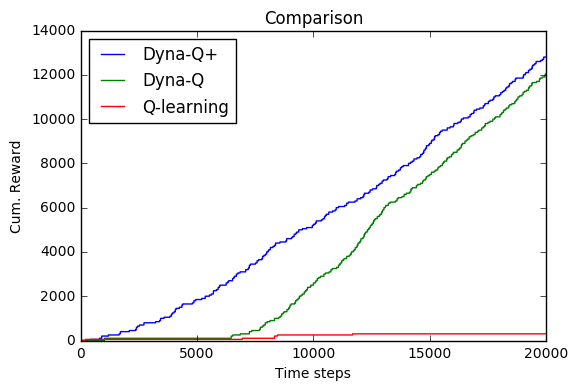

In [154]:
plt.plot(i, cr)
plt.plot(i2, cr2)
plt.plot(i3, cr3)
plt.xlabel('Time steps')
plt.ylabel('Cum. Reward')
plt.title('Comparison')
plt.legend(['Dyna-Q+', 'Dyna-Q', 'Q-learning'], loc='upper left')
plt.show()

In [112]:
class SMDP(MDP):
    def __init__(self, lion_pos=(height - 1, 0), cow_positions=([(0, width - 1)])):
        super().__init__(lion_pos, cow_positions)
    
    @staticmethod
    def _inverse(a):
        if a == Action.UP:
            return Action.DOWN
        elif a == Action.DOWN:
            return Action.UP
        elif a == Action.LEFT:
            return Action.RIGHT
        elif a == Action.RIGHT:
            return Action.LEFT
    
    def _transitions_func(self, s, a):
        prob = random.uniform(0, 1)
        if prob <= 0.7:
            aa = a
        else:
            aa = self._inverse(a)
        return self._move(s, aa), aa

    def reward_transition(self, s, a):
        ss, aa = self._transitions_func(s, a)
        r = self.reward[(s, aa)]
        return r, ss

In [113]:
smdp = SMDP(cow_positions=[(height - 1,width - 1), (0, width - 1)])

In [116]:
_, i_, cr_ = dyna_q_prioritized_sweeping(smdp, alpha=0.8, gamma=0.8, n=5, maxiter=10000, eps=0.8, theta=1)

In [155]:
_, i2_, _, cr2_ = dyna_q(smdp, alpha=0.8, gamma=0.8, n=5, iter_cnt=10000, eps=0.8)

In [115]:
_, i3_, _, cr3_ = dyna_q(smdp, alpha=0.8, gamma=0.8, n=0, iter_cnt=10000, eps=0.8)

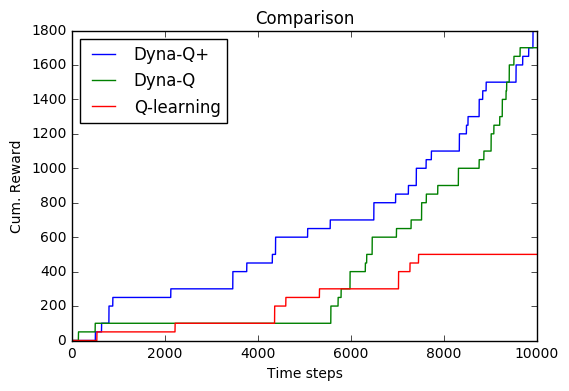

In [156]:
plt.plot(i_, cr_)
plt.plot(i2_, cr2_)
plt.plot(i3_, cr3_)
plt.xlabel('Time steps')
plt.ylabel('Cum. Reward')
plt.title('Comparison')
plt.legend(['Dyna-Q+', 'Dyna-Q', 'Q-learning'], loc='upper left')
plt.show()